# Perkenalan

## Latar Belakang
- Terdapat dua aplikasi pesanan taksi online terkenal di New York, Amerika yaitu Uber dan Lyft. Tentunya kedua aplikasi tersebut akan memberikan harga yang bersaing untuk dipilih oleh konsumennya. Hal ini menimbulkan beberapa pertanyaan:
    - apakah terdapat perbedaan harga yang signifikan dari kedua aplikasi tersebut ?
    - faktor apa saja yang digunakan dari kedua aplikasi tersebut dalam menentukan harga?

## Data
- data yang digunakan bersumber dari kaggle dengan judul 'Uber and Lyft Dataset Boston, MA' yang berisi 57 kolom dengan 693071 baris. Kolom terdiri dari beberapa fitur yang dapat dipertimbangkan untuk penentuan harga dari kedua aplikasi tersebut yaitu distance, cab_type, timestamp, cuaca, suhu, dan masih banyak lagi. 
- data ini merupakan data pemesanan taksi online oleh pelanggan yang dikumpulkan pada 26 November - 19 Desember 2018.
- secara garis besar untuk menentukan perbandingan harga antara Lyft dan Uber akan dilakukan pemisahan dataset antara kedua aplikasi tersebut dan membandingkannya dengan faktor - faktor yang berpengaruh sangat signifikan dengan penentuan harganya.

## Tujuan
- diharapkan nantinya dapat diperoleh perbandingan harga antara Lyft dan Uber, faktor apa saja yang mempengaruhi penentuan harga, serta cara penentuan harga dari kedua aplikasi tersebut dengan menggunakan model regresi linear

# Import Pustaka

In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from numpy import arange
from sklearn.linear_model import LassoCV
from sklearn.model_selection import RepeatedKFold
from sklearn import ensemble
from sklearn.ensemble import GradientBoostingRegressor

# Data Loading

In [2]:
#memuat data yang akan digunakan
df= pd.read_csv('rideshare_kaggle.csv', low_memory=False)
pd.set_option('display.max_columns', None)
df.head(2)
df.shape

(693071, 57)

- data terdiri dari 57 kolom dengan 693071 data pesanan atau baris

In [3]:
# mengecek nilai baris yang terduplikasi
df[df.duplicated()]

,id,timestamp,hour,day,month,datetime,timezone,source,destination,cab_type,product_id,name,price,distance,surge_multiplier,latitude,longitude,temperature,apparentTemperature,short_summary,long_summary,precipIntensity,precipProbability,humidity,windSpeed,windGust,windGustTime,visibility,temperatureHigh,temperatureHighTime,temperatureLow,temperatureLowTime,apparentTemperatureHigh,apparentTemperatureHighTime,apparentTemperatureLow,apparentTemperatureLowTime,icon,dewPoint,pressure,windBearing,cloudCover,uvIndex,visibility.1,ozone,sunriseTime,sunsetTime,moonPhase,precipIntensityMax,uvIndexTime,temperatureMin,temperatureMinTime,temperatureMax,temperatureMaxTime,apparentTemperatureMin,apparentTemperatureMinTime,apparentTemperatureMax,apparentTemperatureMaxTime


- tidak ada baris yang sama

In [4]:
# mengecek data yang hilang pada kolom
df.columns[df.isnull().any()]

Index(['price'], dtype='object')

- terdapat data yang hilang pada kolom 'price'

In [5]:
# pada kolom 'price' terdapat data yang hilang
# menghapus baris dengan nilai 'price' yang hilang
print("data 'price' yang hilang : ", sum(np.isnan(df['price'])))
df.dropna(inplace=True)
print(df.shape)

data 'price' yang hilang :  55095
(637976, 57)


- terdapat 55095 data kosong yang nanti akan mengganggu nilai regresi linear. data yang kosong ini di drop dari data set

In [6]:
print('jam :', (sorted(df.hour.unique())))
print('bulan :', (sorted(df.month.unique())))
print('tanggal :', (sorted(df.day.unique())))

jam : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23]
bulan : [11, 12]
tanggal : [1, 2, 3, 4, 9, 10, 13, 14, 15, 16, 17, 18, 26, 27, 28, 29, 30]


- data yang dicatat selama 24 jam
- dicatat selama 2 bulan yaitu bulan november dan desember. Maka dapat dianggap bahwa bulan pemesanan tidak berpengaruh pada nilai 'price'
- data tidak dicatat setiap hari karena ada tanggal yang tidak disebutkan pada data

In [7]:
pd.crosstab(df.surge_multiplier, df.cab_type)

cab_type,Lyft,Uber
surge_multiplier,,
1.00,286433,330568
1.25,11085,0
1.50,5065,0
1.75,2420,0
2.00,2239,0
2.50,154,0
3.00,12,0


- uber tidak terdapat catatan lonjakan penumpang

# Data Cleaning

In [8]:
# fitur pada dataset
print(df.columns)

Index(['id', 'timestamp', 'hour', 'day', 'month', 'datetime', 'timezone',
       'source', 'destination', 'cab_type', 'product_id', 'name', 'price',
       'distance', 'surge_multiplier', 'latitude', 'longitude', 'temperature',
       'apparentTemperature', 'short_summary', 'long_summary',
       'precipIntensity', 'precipProbability', 'humidity', 'windSpeed',
       'windGust', 'windGustTime', 'visibility', 'temperatureHigh',
       'temperatureHighTime', 'temperatureLow', 'temperatureLowTime',
       'apparentTemperatureHigh', 'apparentTemperatureHighTime',
       'apparentTemperatureLow', 'apparentTemperatureLowTime', 'icon',
       'dewPoint', 'pressure', 'windBearing', 'cloudCover', 'uvIndex',
       'visibility.1', 'ozone', 'sunriseTime', 'sunsetTime', 'moonPhase',
       'precipIntensityMax', 'uvIndexTime', 'temperatureMin',
       'temperatureMinTime', 'temperatureMax', 'temperatureMaxTime',
       'apparentTemperatureMin', 'apparentTemperatureMinTime',
       'apparentTemperat

- terdapat fitur - fitur yang memiliki kemiripan nama seperti time, temperatur, dan merupakan data yang tidak terikat dengan price, hal ini perlu kita selidiki lebih lanjut

In [9]:
# fitur timezone
print(df.timezone.unique())

['America/New_York']


- pada time zone hanya memiliki 1 data yang sama untuk semua pesanan, maka dapat disimpulkan bahwa fitur timezone tidak mempengaruhi 'price'

In [10]:
# fitur long_summary, short_summary, icon
print('long summary: ', df.long_summary.unique())
print('short summary: ', df.short_summary.unique())
print('icon: ', df.icon.unique())

long summary:  [' Rain throughout the day. '
 ' Rain until morning, starting again in the evening. '
 ' Light rain in the morning. ' ' Partly cloudy throughout the day. '
 ' Mostly cloudy throughout the day. '
 ' Light rain in the morning and overnight. '
 ' Light rain until evening. ' ' Foggy in the morning. '
 ' Overcast throughout the day. ' ' Possible drizzle in the morning. '
 ' Rain in the morning and afternoon. ']
short summary:  [' Mostly Cloudy ' ' Rain ' ' Clear ' ' Partly Cloudy ' ' Overcast '
 ' Light Rain ' ' Foggy ' ' Possible Drizzle ' ' Drizzle ']
icon:  [' partly-cloudy-night ' ' rain ' ' clear-night ' ' cloudy ' ' fog '
 ' clear-day ' ' partly-cloudy-day ']


- ketiga fitur tersebut memiliki kategoti yang hampir sama yaitu berkaitan dengan cuaca
- kita asumsikan bahwa ketiga fitur tersebut saling berhubungan dan dapat diwakili oleh satu fitur yaitu short_summary
- kita dapat menghapus fitur lainnya dari dataset

In [11]:
# fitur time
df1=df[['timestamp','windGustTime', 'temperatureHighTime','temperatureLowTime', 
              'apparentTemperatureHighTime','apparentTemperatureLowTime', 'sunriseTime',
              'sunsetTime','uvIndexTime','temperatureMinTime','temperatureMaxTime',
              'apparentTemperatureMinTime','apparentTemperatureMaxTime']]
print(df.shape)
df1.head(2)

(637976, 57)


,timestamp,windGustTime,temperatureHighTime,temperatureLowTime,apparentTemperatureHighTime,apparentTemperatureLowTime,sunriseTime,sunsetTime,uvIndexTime,temperatureMinTime,temperatureMaxTime,apparentTemperatureMinTime,apparentTemperatureMaxTime
0,1.544953e+09,1545015600,1544968800,1545048000,1544968800,1545044400,1544962084,1544994864,1544979600,1545012000,1544968800,1545012000,1544958000
1,1.543284e+09,1543291200,1543251600,1543298400,1543251600,1543291200,1543232969,1543266992,1543251600,1543233600,1543251600,1543291200,1543251600


<AxesSubplot:>

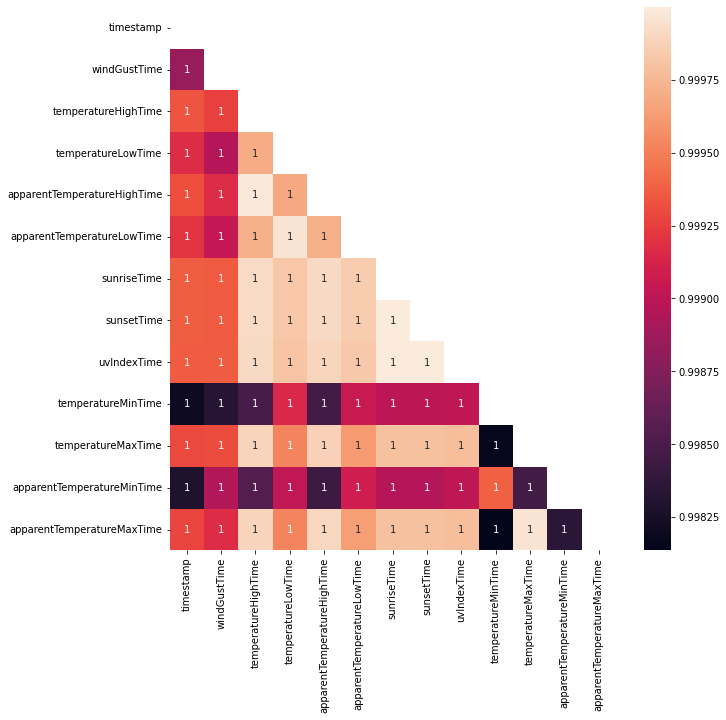

In [12]:
plt.figure(figsize=(10,10))
sns.heatmap(df1.corr(),annot=True, mask=np.triu(df1.corr()))

- fitur time ini memiliki korelasi yang besar satu sama lain
- selain itu kita tahu bahwa fitur time sudah diwakili dengan hour, day, month
- maka fitur time ini dapat di drop dari dataset

In [28]:
fitur = ['day','hour','temperature','apparentTemperature','temperatureHigh', 'temperatureLow',
            'apparentTemperatureHigh','apparentTemperatureLow','temperatureMin','temperatureMax',
            'apparentTemperatureMin','apparentTemperatureMax','precipIntensity','precipProbability',
            'humidity','humidity','windSpeed','windGust','visibility','dewPoint','pressure','windBearing',
            'cloudCover','uvIndex','visibility.1','ozone','moonPhase','precipIntensityMax']

custom_palette = ['pink', 'grey']
sns.set_palette(custom_palette)

for col in fitur:
    print(col)
    plt.figure()
    sns.lmplot(x=col, y='price', data=df, hue='cab_type', ci=None)
    plt.show()

day


KeyError: "None of [Index(['cab_type', 'day', 'price'], dtype='object')] are in the [columns]"

<Figure size 432x288 with 0 Axes>

- dari visualisasi dari beberapa fitur tidak memiliki kecenderungan kenaikan harga pada peningkatan nilai dari fitur atau bersifat konstan dan tidak memiliki keterikatan dengan 'price'
- hal ini menunjukan bahwa fitur yang disebutkan kita asumsikan tidak memiliki pengaruh pada kenaikan nilai 'price'

In [14]:
# fitur id merupakan identitas dari setiap pesanan yang tidak terikat dengan 'price' 
# fitur latitude, longitude, source, destination yang kita asumsikan berhubungan dengan 'distance'
# fitur tersebut akan menentukan 'distance' yang ditempuh


In [15]:
# menghapus fitur yang tidak dibutuhkan
df = df.drop(['month','day','hour','datetime','timezone','long_summary','icon','timestamp','datetime',
                      'windGustTime', 'temperatureHighTime','temperatureLowTime', 'apparentTemperatureHighTime',
                      'apparentTemperatureLowTime', 'sunriseTime','sunsetTime','uvIndexTime','temperatureMinTime',
                      'temperatureMaxTime','apparentTemperatureMinTime','apparentTemperatureMaxTime',
                      'temperature','apparentTemperature','temperatureHigh', 'temperatureLow','apparentTemperatureHigh',
                      'apparentTemperatureLow','temperatureMin','temperatureMax','apparentTemperatureMin',
                      'apparentTemperatureMax','precipIntensity','precipProbability','humidity','humidity','windSpeed',
                      'windGust','visibility','dewPoint','pressure','windBearing','cloudCover','uvIndex','visibility.1','ozone',
                      'moonPhase','precipIntensityMax','id','source','destination','latitude','longitude'],axis=1)
print(df.shape)
df.head(2)

(637976, 7)


,cab_type,product_id,name,price,distance,surge_multiplier,short_summary
0,Lyft,lyft_line,Shared,5.0,0.44,1.0,Mostly Cloudy
1,Lyft,lyft_premier,Lux,11.0,0.44,1.0,Rain


- fitur - fitur yang tidak diperlukan dapat dihapus dari dataset untuk mempermudah kita dalam melakukan analisis nantinya

# Eksplorasi Data

In [16]:
# kategori yang ada pada setiap kolom
kategori = df.select_dtypes(include=['object','category']).columns.tolist()
for col in kategori:
    print(f'{col} : {df[col].unique()}')
    print()

cab_type : ['Lyft' 'Uber']

product_id : ['lyft_line' 'lyft_premier' 'lyft' 'lyft_luxsuv' 'lyft_plus' 'lyft_lux'
 '6f72dfc5-27f1-42e8-84db-ccc7a75f6969'
 '6c84fd89-3f11-4782-9b50-97c468b19529'
 '55c66225-fbe7-4fd5-9072-eab1ece5e23e'
 '9a0e7b09-b92b-4c41-9779-2ad22b4d779d'
 '6d318bcc-22a3-4af6-bddd-b409bfce1546'
 '997acbb5-e102-41e1-b155-9df7de0a73f2']

name : ['Shared' 'Lux' 'Lyft' 'Lux Black XL' 'Lyft XL' 'Lux Black' 'UberXL'
 'Black' 'UberX' 'WAV' 'Black SUV' 'UberPool']

short_summary : [' Mostly Cloudy ' ' Rain ' ' Clear ' ' Partly Cloudy ' ' Overcast '
 ' Light Rain ' ' Foggy ' ' Possible Drizzle ' ' Drizzle ']



In [17]:
# menamai ulang kolom dari dataset sesuai dengan nilai dalam kolom
df.rename({"cab_type": "merk", "name": "tipe", "short_summary": "cuaca",
                     "surge_multiplier":"lonjakan", "price":"harga",'distance':'jarak' }, 
                     axis=1, inplace=True)
df.head(2)

,merk,product_id,tipe,harga,jarak,lonjakan,cuaca
0,Lyft,lyft_line,Shared,5.0,0.44,1.0,Mostly Cloudy
1,Lyft,lyft_premier,Lux,11.0,0.44,1.0,Rain


In [18]:
# membagi dataset sesuai dengan merk yaitu Lyft dan Uber
df_lyft = df[:][df.merk == "Lyft"]
df_uber = df[:][df.merk == "Uber"]

In [19]:
# analisis kesamaan product_id dan tipe taksi untuk merk lyft
pd.crosstab(df_lyft.product_id,df_lyft.tipe)

tipe,Lux,Lux Black,Lux Black XL,Lyft,Lyft XL,Shared
product_id,,,,,,
lyft,0,0,0,51235,0,0
lyft_line,0,0,0,0,0,51233
lyft_lux,0,51235,0,0,0,0
lyft_luxsuv,0,0,51235,0,0,0
lyft_plus,0,0,0,0,51235,0
lyft_premier,51235,0,0,0,0,0


In [20]:
# analisis kesamaan product_id dan tipe taksi untuk merk uber
pd.crosstab(df_uber.product_id,df_uber.tipe)

tipe,Black,Black SUV,UberPool,UberX,UberXL,WAV
product_id,,,,,,
55c66225-fbe7-4fd5-9072-eab1ece5e23e,0,0,0,55094,0,0
6c84fd89-3f11-4782-9b50-97c468b19529,55095,0,0,0,0,0
6d318bcc-22a3-4af6-bddd-b409bfce1546,0,55096,0,0,0,0
6f72dfc5-27f1-42e8-84db-ccc7a75f6969,0,0,0,0,55096,0
997acbb5-e102-41e1-b155-9df7de0a73f2,0,0,55091,0,0,0
9a0e7b09-b92b-4c41-9779-2ad22b4d779d,0,0,0,0,0,55096


- product_id merupakan kode untuk setiap tipe taksi sehingga kita dapat menggunakan salah satu saja untuk analisis 

In [21]:
# menghapus product_id dalam dataset
df_uber= df_uber.drop(['product_id'], axis=1)
df_lyft= df_lyft.drop(['product_id'], axis=1)
df=df.drop(['product_id'],axis=1)

<AxesSubplot:xlabel='harga', ylabel='cuaca'>

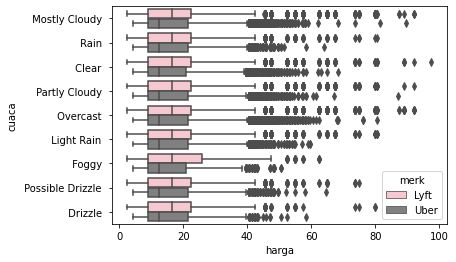

In [22]:
# pengaruh cuaca terhadap harga
custom_palette = ['pink', 'grey']
sns.set_palette(custom_palette)
sns.boxplot(x="harga", y="cuaca", hue="merk", data=df)

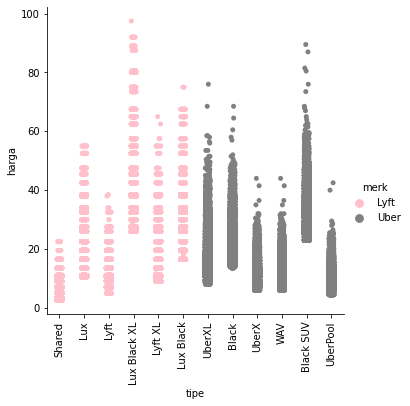

In [23]:
# pengaruh tipe taksi terhadap harga
ax = sns.catplot(x='tipe', y = 'harga', hue='merk', data=df)
ax.set_xticklabels(rotation=90)
plt.show()

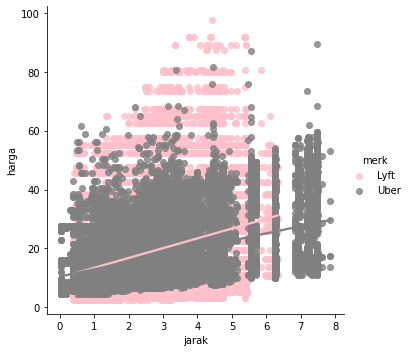

In [25]:
# pengaruh jarak terhadap harga
sns.lmplot(x='jarak', y='harga', hue='merk', data=df, ci=None)

<AxesSubplot:xlabel='harga', ylabel='merk'>

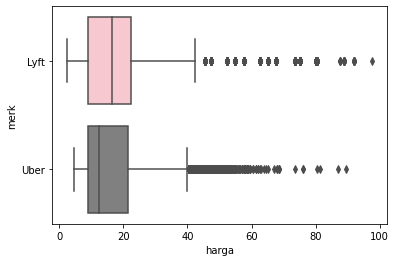

In [26]:
# pengaruh merk taksi terhadap harga
sns.boxplot(x='harga', y='merk', data=df, orient="h")

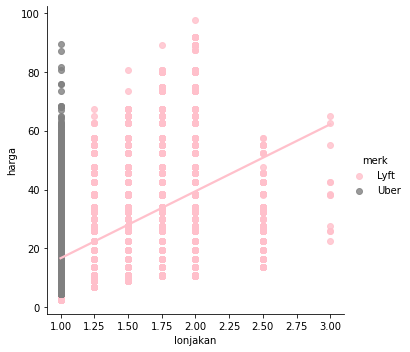

In [27]:
sns.lmplot(x='lonjakan', y='harga', hue='merk', data=df, ci=None)

In [ ]:
df.head(2)

,merk,tipe,harga,jarak,lonjakan,cuaca
0,Lyft,Shared,5.0,0.44,1.0,Mostly Cloudy
1,Lyft,Lux,11.0,0.44,1.0,Rain


- setelah dilakukan visualisasi terhadap fitur yang tersisa (merk, tipe, harga, jarak, dan cuaca) diketahui fitur tersebut memiliki hubungan dengan penentuan harga
-  penentuan harga pada merk uber tidak dipengaruhi dengan nilai lonjakan sehingga dapat di drop dari dataset

# Data Preprocessing

In [31]:
# melabeli data yang akan digunakan
for i in df_lyft.tipe.unique():
    df_lyft[i] = (df_lyft.tipe == i).astype('int')

for i in df_lyft.cuaca.unique():
    df_lyft[i] = (df_lyft.cuaca == i).astype('int')

for i in df_uber.tipe.unique():
    df_uber[i] = (df_uber.tipe == i).astype('int')

for i in df_uber.cuaca.unique():
    df_uber[i] = (df_uber.cuaca == i).astype('int')

In [38]:
print(df_lyft.columns)
df_lyft.head(2)

Index(['merk', 'tipe', 'harga', 'jarak', 'lonjakan', 'cuaca', 'Shared', 'Lux',
       'Lyft', 'Lux Black XL', 'Lyft XL', 'Lux Black', ' Mostly Cloudy ',
       ' Rain ', ' Clear ', ' Partly Cloudy ', ' Overcast ', ' Light Rain ',
       ' Foggy ', ' Possible Drizzle ', ' Drizzle '],
      dtype='object')


,merk,tipe,harga,jarak,lonjakan,cuaca,Shared,Lux,Lyft,Lux Black XL,Lyft XL,Lux Black,Mostly Cloudy,Rain,Clear,Partly Cloudy,Overcast,Light Rain,Foggy,Possible Drizzle,Drizzle
0,Lyft,Shared,5.0,0.44,1.0,Mostly Cloudy,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,Lyft,Lux,11.0,0.44,1.0,Rain,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0


In [35]:
df_uber=df_uber.drop(['lonjakan'], axis=1)
df.head(2)

,merk,tipe,harga,jarak,lonjakan,cuaca
0,Lyft,Shared,5.0,0.44,1.0,Mostly Cloudy
1,Lyft,Lux,11.0,0.44,1.0,Rain


In [36]:
print(df_uber.columns)

Index(['merk', 'tipe', 'harga', 'jarak', 'cuaca', 'UberXL', 'Black', 'UberX',
       'WAV', 'Black SUV', 'UberPool', ' Overcast ', ' Clear ',
       ' Mostly Cloudy ', ' Light Rain ', ' Possible Drizzle ',
       ' Partly Cloudy ', ' Rain ', ' Foggy ', ' Drizzle '],
      dtype='object')


In [49]:
# memilih data yang akan digunakan untuk proses modeling pada merk Lyft
X_lyft = df_lyft[['jarak', 'lonjakan', 'Shared', 'Lux', 'Lyft', 'Lux Black XL', 'Lyft XL', 'Lux Black', ' Mostly Cloudy ',
                         ' Rain ', ' Clear ', ' Partly Cloudy ', ' Overcast ', ' Light Rain ',' Foggy ', ' Possible Drizzle ', 
                         ' Drizzle ']]
y_lyft= df_lyft['harga']

lyft_X_train, lyft_X_test, lyft_y_train, lyft_y_test = train_test_split(X_lyft, y_lyft, test_size=0.20,random_state=325)

In [50]:
# memilih data yang akan digunakan untuk proses modeling pada merk Uber
X_uber = df_uber[[ 'jarak', 'UberXL', 'Black', 'UberX','WAV', 'Black SUV', 'UberPool', ' Overcast ', ' Clear ',
                                ' Mostly Cloudy ', ' Light Rain ', ' Possible Drizzle ',' Partly Cloudy ', ' Rain ', ' Foggy ', 
                                ' Drizzle ']]
y_uber=df_uber[['harga']]

uber_X_train, uber_X_test, uber_y_train, uber_y_test = train_test_split(X_uber , y_uber,test_size=0.20, random_state=325)

# Model

## Regresi Linear

Linear Regression Lyft train R squared: 0.9365
Linear Regression Lyft test R squared: 0.9363
Linear Regression Lyft test RMSE: 2.5326
Linear Regression Lyft Accuracy: 84.99 %.


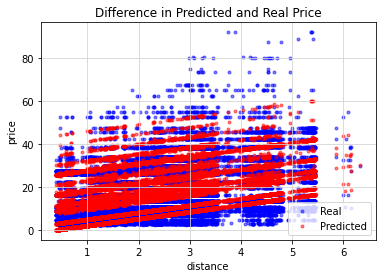

In [64]:
# Regresi Linear untuk Lyft
lr = LinearRegression() 
lm_model = lr.fit(lyft_X_train, lyft_y_train)
lyft_y_pred = lm_model.predict(lyft_X_test)
l_lr_train_r2 = lr.score(lyft_X_train, lyft_y_train)
l_lr_test_r2 = lr.score(lyft_X_test, lyft_y_test)
print('Linear Regression Lyft train R squared: %.4f' % l_lr_train_r2)
print('Linear Regression Lyft test R squared: %.4f' % l_lr_test_r2)

lyft_lr_mse = mean_squared_error(lyft_y_pred, lyft_y_test)
lyft_lr_rmse = np.sqrt(lyft_lr_mse)
print('Linear Regression Lyft test RMSE: %.4f' % lyft_lr_rmse)

errors = abs(lyft_y_pred - lyft_y_test)
mape = 100 * (errors / lyft_y_test)
lyft_lr_accuracy = 100 - np.mean(mape)
print('Linear Regression Lyft Accuracy:', round(lyft_lr_accuracy, 2), '%.')

# Define x axis
x_axis = lyft_X_test.jarak

# Build scatterplot
plt.scatter(x_axis, lyft_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, lyft_y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

Linear Regression Uber train R squared: 0.9200
Linear Regression Uber test R squared: 0.9188
Linear Regression Uber test RMSE: 2.4426
Linear Regression Uber Accuracy: 84.99 %.


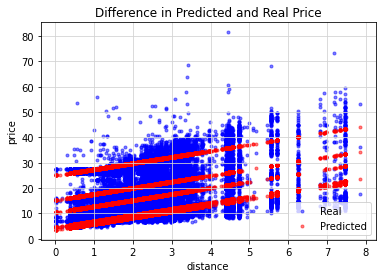

In [59]:
# Regresi Linear Uber

lr = LinearRegression() 
lm_model = lr.fit(uber_X_train, uber_y_train)
uber_y_pred = lm_model.predict(uber_X_test)
u_lr_train_r2 = lr.score(uber_X_train, uber_y_train)
u_lr_test_r2 = lr.score(uber_X_test, uber_y_test)
print('Linear Regression Uber train R squared: %.4f' % u_lr_train_r2)
print('Linear Regression Uber test R squared: %.4f' % u_lr_test_r2)

uber_lr_mse = mean_squared_error(uber_y_pred, uber_y_test)
uber_lr_rmse = np.sqrt(uber_lr_mse)
print('Linear Regression Uber test RMSE: %.4f' % uber_lr_rmse)

errors = abs(uber_y_pred - uber_y_test)
mape = 100 * (errors / uber_y_test)
uber_lr_accuracy = 100 - np.mean(mape)
print('Linear Regression Uber Accuracy:', round(lyft_lr_accuracy, 2), '%.')

# Define x axis
x_axis = uber_X_test.jarak

# Build scatterplot
plt.scatter(x_axis, uber_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, uber_y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

# LASSO

0.003923518277292399
LASSO Lyft train R squared is: 0.9365
LASSO Lyft test R squared is: 0.9363
LASSO test RMSE: 2.5328
LASSO Lyft Accuracy: 85.05 %.


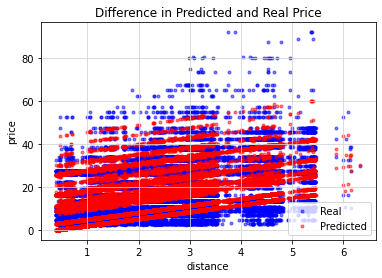

In [68]:
# LASSO untuk Lyft
#cv
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
lyft_lasso_model = LassoCV(cv=cv)

#fit model
lyft_lasso_model.fit(lyft_X_train, lyft_y_train)
lyft_y_pred = lyft_lasso_model.predict(lyft_X_test)

#display lambda that produced the lowest test MSE
print(lyft_lasso_model.alpha_)
l_lasso_train_r2 = lyft_lasso_model.score(lyft_X_train,lyft_y_train)
l_lasso_test_r2 = lyft_lasso_model.score(lyft_X_test,lyft_y_test)
print('LASSO Lyft train R squared is: %.4f' % l_lasso_train_r2)
print('LASSO Lyft test R squared is: %.4f' % l_lasso_test_r2)

lyft_lasso_mse = mean_squared_error(lyft_y_pred, lyft_y_test)
lyft_lasso_rmse = np.sqrt(lyft_lasso_mse)
print('LASSO test RMSE: %.4f' % lyft_lasso_rmse)

errors = abs(lyft_y_pred - lyft_y_test)
mape = 100 * (errors / lyft_y_test)
lyft_lasso_accuracy = 100 - np.mean(mape)
print('LASSO Lyft Accuracy:', round(lyft_lasso_accuracy, 2), '%.')

# Define x axis
x_axis = lyft_X_test.jarak

# Build scatterplot
plt.scatter(x_axis, lyft_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, lyft_y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

/home/jefl5/.local/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:1570: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


0.0033933817828505916
LASSO Uber train R squared is: 0.9200
LASSO Uber test R squared is: 0.9187
LASSO Uber test RMSE: 2.4428
LASSO Lyft Accuracy: harga    88.15
dtype: float64 %.


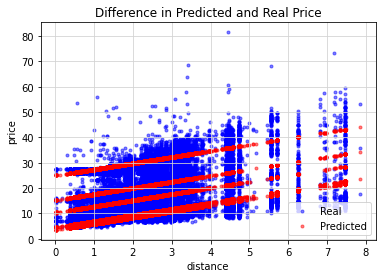

In [69]:
# LASSO untuk Uber
cv = RepeatedKFold(n_splits=10, n_repeats=3, random_state=1)

#define model
uber_lasso_model = LassoCV(cv=cv)

#fit model
uber_lasso_model.fit(uber_X_train, uber_y_train)
uber_y_pred = uber_lasso_model.predict(uber_X_test)
uber_y_pred = uber_y_pred.reshape(66114,1)

#display lambda that produced the lowest test MSE
print(uber_lasso_model.alpha_)
u_lasso_train_r2 = uber_lasso_model.score(uber_X_train,uber_y_train)
u_lasso_test_r2 = uber_lasso_model.score(uber_X_test,uber_y_test)
print('LASSO Uber train R squared is: %.4f' % u_lasso_train_r2)
print('LASSO Uber test R squared is: %.4f' % u_lasso_test_r2)

uber_lasso_mse = mean_squared_error(uber_y_pred, uber_y_test)
uber_lasso_rmse = np.sqrt(uber_lasso_mse)
print('LASSO Uber test RMSE: %.4f' % uber_lasso_rmse)

errors = abs(uber_y_pred - uber_y_test)
mape = 100 * (errors / uber_y_test)
uber_lasso_accuracy = 100 - np.mean(mape)
print('LASSO Lyft Accuracy:', round(uber_lasso_accuracy, 2), '%.')
# Define x axis
x_axis = uber_X_test.jarak

# Build scatterplot
plt.scatter(x_axis, uber_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, uber_y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

## Gradient Boosting

Gradient Boosting Lyft train R squared is: 0.9759
Gradient Boosting Lyft test R squared": 0.9759
Gradient Boosting RMSE: 1.5597
Gradient Boosting Lyft Accuracy: 91.16 %.


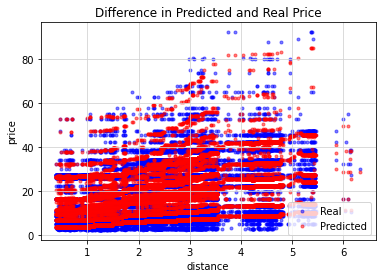

In [76]:
# GBR untuk lyft
gbr = ensemble.GradientBoostingRegressor()
gbr.fit(lyft_X_train, lyft_y_train)
l_gbr_train_r2 = gbr.score(lyft_X_train,lyft_y_train)
l_gbr_test_r2 = gbr.score(lyft_X_test, lyft_y_test)
print('Gradient Boosting Lyft train R squared is: %.4f' % l_gbr_train_r2)
print('Gradient Boosting Lyft test R squared": %.4f' % l_gbr_test_r2)

y_pred = gbr.predict(lyft_X_test)
lyft_gbr_mse = mean_squared_error(y_pred, lyft_y_test)
lyft_gbr_rmse = np.sqrt(lyft_gbr_mse)
print('Gradient Boosting RMSE: %.4f' % lyft_gbr_rmse)

errors = abs(y_pred - lyft_y_test)
mape = 100 * (errors / lyft_y_test)
lyft_gbr_accuracy = 100 - np.mean(mape)
print('Gradient Boosting Lyft Accuracy:', round(lyft_gbr_accuracy, 2), '%.')

# Define x axis
x_axis = lyft_X_test.jarak

# Build scatterplot
plt.scatter(x_axis, lyft_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

In [77]:
# GBR untuk Uber
gbr = ensemble.GradientBoostingRegressor()
gbr.fit(uber_X_train, uber_y_train)
u_gbr_train_r2 = gbr.score(uber_X_train,uber_y_train)
u_gbr_test_r2 = gbr.score(uber_X_test, uber_y_test)
print('Gradient Boosting Uber train R squared is: %.4f' % u_gbr_train_r2)
print('Gradient Boosting Uber test R squared": %.4f' % u_gbr_train_r2)

y_pred = gbr.predict(uber_X_test)
uber_gbr_mse = mean_squared_error(y_pred, uber_y_test)
uber_gbr_rmse = np.sqrt(uber_gbr_mse)
print('Gradient Boosting RMSE: %.4f' % uber_gbr_rmse)

errors = abs(y_pred - uber_y_test)
mape = 100 * (errors / uber_y_test)
uber_gbr_accuracy = 100 - np.mean(mape)
print('Gradient Boosting Uber Accuracy:', round(uber_gbr_accuracy, 2), '%.')

# Define x axis
x_axis = uber_X_test.jarak

# Build scatterplot
plt.scatter(x_axis, uber_y_test, c = 'b', alpha = 0.5, marker = '.', label = 'Real')
plt.scatter(x_axis, y_pred, c = 'r', alpha = 0.5, marker = '.', label = 'Predicted')
plt.xlabel('distance')
plt.ylabel('price') 
plt.title("Difference in Predicted and Real Price")
plt.grid(color = '#D3D3D3', linestyle = 'solid')
plt.legend(loc = 'lower right')
plt.show()

/home/jefl5/.local/lib/python3.8/site-packages/sklearn/ensemble/_gb.py:494: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Gradient Boosting Uber train R squared is: 0.9476
Gradient Boosting Uber test R squared": 0.9476
Gradient Boosting RMSE: 1.9869


ValueError: Unable to coerce to Series, length must be 1: given 66114

# Kesimpulan